In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bisect

In [3]:
from scipy.signal import argrelextrema
from statsmodels.nonparametric.smoothers_lowess import lowess
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
import following_motif_method.matrixProfile as matrixProfile

In [6]:
from tqdm import tqdm

In [7]:
def ts_visualization(ts, label='Time Series',color="blue",size=(15, 10)):
  plt.figure(figsize=size)
  plt.subplot(2, 1, 1)
  plt.title(label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid()
  plt.plot(ts, label=label, color=color)

In [8]:
def leadfollow_visualization(ts1,ts2):
  plt.figure(figsize=(15, 10))

  plt.subplot(2, 1, 1)
  plt.title('Leading Time Series (Adam Singing)', fontsize=30)
  plt.xlabel('Time', fontsize=30)
  plt.ylabel('Value', fontsize=30)
  plt.xticks(fontsize=25)
  plt.yticks(fontsize=25)
  plt.grid()
  plt.plot(ts1, label='Leading signal', color='blue')

  plt.subplot(2, 1, 2)
  plt.title('Following Time Series (Matt Singing)', fontsize=30)
  plt.xlabel('Time', fontsize=30)
  plt.ylabel('Value', fontsize=30)
  plt.xticks(fontsize=25)
  plt.yticks(fontsize=25)
  plt.grid()
  plt.plot(ts2, label='Following signal', color='red')

  plt.tight_layout()
  plt.show()

# Dataset 

In [9]:
def leading_ts1(randseed=0,k_motif=2,varied_len=False,one_motif=False):

  np.random.seed(randseed)

  #-------------------------------------------------------------------------------------------

  if varied_len:

    high = 1000
    N = np.random.randint(int(0.1*high),high=high)

    motif_start_list   = [0]
    discord_start_list = [0]

    while (motif_start_list[-1]<N) and (discord_start_list[-1]<N):
     
      # motif length
      motif_length   = np.random.randint(int(N*0.025),high=int(N*0.1))

      # discord length
      discord_length = int(motif_length*5)
      while (N%(discord_length+motif_length) != 0) and (discord_length>int(N*0.6)): discord_length += 1

      #new motif and discord start
      discord_start_list.append(motif_start_list[-1]+motif_length)
      motif_start_list.append(discord_start_list[-1]+discord_length)

    discord_start_list = discord_start_list[1:]
    if motif_start_list[-1] > N:
      motif_start_list = motif_start_list[:-1]
      if discord_start_list[-1] > N:
        discord_start_list = discord_start_list[:-1]

  else:
    N = 1000

    if one_motif:
      motif_length   = np.random.randint(int(N*0.1),high=int(N*0.15))
      discord_length = int(motif_length*5)
      motif_start_list   = [int(N*np.random.randint(int(15),high=int(30))/100)+motif_length]

    else:
      motif_length   = np.random.randint(int(N*0.025),high=int(N*0.1))
      discord_length = int(motif_length*1.2)
      motif_start_list   = [i for i in range(0,N,int(motif_length+discord_length))]

  t = np.arange(N)
  time_series = np.zeros(N)

  #-------------------------------------------------------------------------------------------

  n = 0
  i = 0
  motif = [[np.random.randint(low=2,high=20)/10,np.random.randint(low=300,high=500)/100] for i in range(k_motif)]
  #motif = [[np.random.randint(low=2,high=10)/10,np.random.randint(low=300,high=500)/10] for i in range(k_motif)]

  if motif_start_list[0] != 0:
    time_series[0:motif_start_list[0]] += (np.random.normal(0, 0.5,len(time_series[0:motif_start_list[0]])))

  while n<len(motif_start_list):
    if k_motif <= 1: i = 0
    try:
      time_series[motif_start_list[n]:motif_start_list[n]+motif_length] += np.sin(motif[i][0] * np.pi * t[:motif_length]/motif[i][1])
    except ValueError:
      time_series[motif_start_list[n]:N] += np.sin(motif[i][0] * np.pi * t[:int(N-motif_start_list[n])]/motif[i][1])
      break

    try:
      time_series[motif_start_list[n]+motif_length:motif_start_list[n+1]] += (np.random.normal(0, 0.5, discord_length))
    except IndexError:
      time_series[motif_start_list[n]+motif_length:N] += (np.random.normal(0, 0.5, (N-motif_start_list[n]-motif_length)))

    n += 1
    i += 1
    if i == len(motif): i = 0

  #-------------------------------------------------------------------------------------------

  time_series += (np.random.normal(0, 0.1, N))
  time_series += (np.random.normal(0, 0.1, N))

  #-------------------------------------------------------------------------------------------
  if not varied_len:
    motif_interval = [[x for x in motif_start_list],[x+motif_length for x in motif_start_list]]
    

    return (time_series, motif_interval)

  return time_series

In [10]:
def following_ts1(leading_ts,randseed=0,uncontinuous=True,ground_truth=False):

  np.random.seed(randseed)

  leading_signal = leading_ts[0].copy()
  N              = (leading_signal.shape)[0]
  percent        = np.random.randint(low=20,high=35)/100
  N_first_signal = int(np.ceil(N*percent))
  N_follow       = N - N_first_signal

  degree_of_noise = 3
  noise = 0.5

  first_signal = np.random.normal(0, noise, N_first_signal)

  #leader interval
  lead_motif_start = list(leading_ts[1][0])
  lead_motif_stop  = list(leading_ts[1][1])

  motif_start,motif_stop = [],[]

  #following time series generating
  if uncontinuous:

    time_series = np.zeros(N)
    cutting_point = int(len(time_series)/2)

    percent        = np.random.randint(low=10,high=15)/100
    second_N       = int(len(time_series)*percent)

    interrupt = True

    for t in range(N):
      lag = np.random.randint(0, min(t, degree_of_noise) + 1)
      time_series[t] = leading_signal[t - lag]

      if t in lead_motif_start:
        if t<cutting_point:
          motif_start.append(t+N_first_signal)
        else:
          motif_start.append(t+N_first_signal+second_N)

      if t in lead_motif_stop:
        if t<cutting_point:
          motif_stop.append(t+N_first_signal)
        elif (t in range(cutting_point,cutting_point+second_N+1)) and interrupt:
          motif_stop.append(cutting_point+N_first_signal)
          interrupt = False
        else:
          motif_stop.append(second_N+N_first_signal+t)

    time_series1 = time_series[:cutting_point]
    time_series2 = time_series[cutting_point:]

    percent        = np.random.randint(low=10,high=15)/100
    second_signal = np.random.normal(0, noise, second_N)

    time_series = np.hstack((first_signal,time_series1,second_signal,time_series2))[:N]

  else:
    time_series = np.zeros(N)
    for t in range(N):
      lag = np.random.randint(0, min(t, degree_of_noise) + 1)
      time_series[t] = leading_signal[t - lag]

      if t in lead_motif_start:
        motif_start.append(t+N_first_signal)
      if t in lead_motif_stop:
        motif_stop.append(t+N_first_signal)

    time_series = np.hstack((first_signal,time_series))[:N]

  # adding noise
  time_series += np.random.normal(0, 0.1, N)
  time_series += (np.random.normal(0, 0.1, N))

  #motif_interval
  motif_start = [x for x in motif_start if x<N]
  motif_stop = [x for x in motif_stop if x<N]

  motif_interval = [motif_start[:len(motif_stop)],motif_stop]
  #print(motif_interval)

  if ground_truth:
    motif_start = motif_start[:len(motif_stop)]

    keys   = list(range(len(motif_start)))
    values = []
    for i in range(len(motif_start)):
      pair_result = {
          "leader_interval" : [lead_motif_start[i],lead_motif_stop[i]],
          "follower_interval":[motif_start[i],motif_stop[i]]
      }
      values.append(pair_result)
    result = dict(zip(keys,values))

    return (time_series, result)

  return (time_series, motif_interval)

In [11]:
def leading_ts(randseed=0,k_motif=2,varied_len=False,one_motif=False):

  np.random.seed(randseed)

  #-------------------------------------------------------------------------------------------

  if varied_len:

    high = 1000
    N = np.random.randint(int(0.1*high),high=high)

    motif_start_list   = [0]
    discord_start_list = [0]

    while (motif_start_list[-1]<N) and (discord_start_list[-1]<N):
     
      # motif length
      motif_length   = np.random.randint(int(N*0.025),high=int(N*0.1))

      # discord length
      discord_length = int(motif_length*5)
      while (N%(discord_length+motif_length) != 0) and (discord_length>int(N*0.6)): discord_length += 1

      #new motif and discord start
      discord_start_list.append(motif_start_list[-1]+motif_length)
      motif_start_list.append(discord_start_list[-1]+discord_length)

    discord_start_list = discord_start_list[1:]
    if motif_start_list[-1] > N:
      motif_start_list = motif_start_list[:-1]
      if discord_start_list[-1] > N:
        discord_start_list = discord_start_list[:-1]

  else:
    N = 1000

    if one_motif:
      motif_length   = np.random.randint(int(N*0.1),high=int(N*0.15))
      discord_length = int(motif_length*5)
      motif_start_list   = [int(N*np.random.randint(int(15),high=int(30))/100)+motif_length]

    else:
      motif_length   = np.random.randint(int(N*0.025),high=int(N*0.1))
      discord_length = int(motif_length*1.2)
      motif_start_list   = [i for i in range(0,N,int(motif_length+discord_length))]

  t = np.arange(N)
  time_series = np.zeros(N)

  #-------------------------------------------------------------------------------------------

  n = 0
  i = 0
  motif = [[np.random.randint(low=2,high=20)/10,np.random.randint(low=300,high=500)/100] for i in range(k_motif)]
  #motif = [[np.random.randint(low=2,high=10)/10,np.random.randint(low=30,high=50)] for i in range(k_motif)]

  if motif_start_list[0] != 0:
    time_series[0:motif_start_list[0]] += (np.random.normal(0, 0.5,len(time_series[0:motif_start_list[0]])))

  while n<len(motif_start_list):
    factor = np.random.randint(low=1,high=7)
    if k_motif <= 1: i = 0
    try:
      time_series[motif_start_list[n]:motif_start_list[n]+motif_length] += np.sin(motif[i][0] * np.pi * t[:motif_length]/motif[i][1])
    except ValueError:
      time_series[motif_start_list[n]:N] += np.sin(motif[i][0] * np.pi * t[:int(N-motif_start_list[n])]/motif[i][1])
      break

    #if i%3==0: factor=5
    try:
      time_series[motif_start_list[n]+motif_length:motif_start_list[n+1]] += (np.random.normal(0, 0.5, discord_length))*factor
    except IndexError:
      time_series[motif_start_list[n]+motif_length:N] += (np.random.normal(0, 0.5, (N-motif_start_list[n]-motif_length)))*factor

    n += 1
    i += 1
    if i == len(motif): i = 0

  #-------------------------------------------------------------------------------------------

  time_series += (np.random.normal(0, 0.1, N))
  time_series += (np.random.normal(0, 0.1, N))

  #-------------------------------------------------------------------------------------------
  if not varied_len:
    motif_interval = [[x for x in motif_start_list],[x+motif_length for x in motif_start_list]]
    

    return (time_series, motif_interval)

  return time_series

In [12]:
def following_ts(leading_ts,randseed=0,uncontinuous=True,ground_truth=False):

  np.random.seed(randseed)

  leading_signal = leading_ts[0].copy()
  N              = (leading_signal.shape)[0]
  percent        = np.random.randint(low=20,high=35)/100
  N_first_signal = int(np.ceil(N*percent))
  N_follow       = N - N_first_signal

  degree_of_noise = 3
  noise = 0.5

  first_signal = np.random.normal(0, noise, N_first_signal)*5

  #leader interval
  lead_motif_start = list(leading_ts[1][0])
  lead_motif_stop  = list(leading_ts[1][1])

  motif_start,motif_stop = [],[]

  #following time series generating
  if uncontinuous:

    time_series = np.zeros(N)
    cutting_point = int(len(time_series)/2)

    percent        = np.random.randint(low=10,high=15)/100
    second_N       = int(len(time_series)*percent)

    interrupt = True

    for t in range(N):
      lag = np.random.randint(0, min(t, degree_of_noise) + 1)
      time_series[t] = leading_signal[t - lag]

      if t in lead_motif_start:
        if t<cutting_point:
          motif_start.append(t+N_first_signal)
        else:
          motif_start.append(t+N_first_signal+second_N)

      if t in lead_motif_stop:
        if t<cutting_point:
          motif_stop.append(t+N_first_signal)
        elif (t in range(cutting_point,cutting_point+second_N+1)) and interrupt:
          motif_stop.append(cutting_point+N_first_signal)
          interrupt = False
        else:
          motif_stop.append(second_N+N_first_signal+t)

    time_series1 = time_series[:cutting_point]
    time_series2 = time_series[cutting_point:]

    percent        = np.random.randint(low=10,high=15)/100
    second_signal = np.random.normal(0, noise, second_N)*5

    time_series = np.hstack((first_signal,time_series1,second_signal,time_series2))[:N]

  else:
    time_series = np.zeros(N)
    for t in range(N):
      lag = np.random.randint(0, min(t, degree_of_noise) + 1)
      time_series[t] = leading_signal[t - lag]

      if t in lead_motif_start:
        motif_start.append(t+N_first_signal)
      if t in lead_motif_stop:
        motif_stop.append(t+N_first_signal)

    time_series = np.hstack((first_signal,time_series))[:N]

  # adding noise
  time_series += np.random.normal(0, 0.1, N)
  time_series += (np.random.normal(0, 0.1, N))

  #motif_interval
  motif_start = [x for x in motif_start if x<N]
  motif_stop = [x for x in motif_stop if x<N]

  motif_interval = [motif_start[:len(motif_stop)],motif_stop]
  #print(motif_interval)

  if ground_truth:
    motif_start = motif_start[:len(motif_stop)]

    keys   = list(range(len(motif_start)))
    values = []
    for i in range(len(motif_start)):
      pair_result = {
          "leader_interval" : [lead_motif_start[i],lead_motif_stop[i]],
          "follower_interval":[motif_start[i],motif_stop[i]]
      }
      values.append(pair_result)
    result = dict(zip(keys,values))

    return (time_series, result)

  return (time_series, motif_interval)

In [13]:
leader_list_1   = [leading_ts1(randseed=i,k_motif=1,varied_len=False,one_motif=True) for i in range(1000)]
follower_list_1 = [following_ts1(leader_list_1[i],randseed= i,uncontinuous=False)    for i in range(1000)]

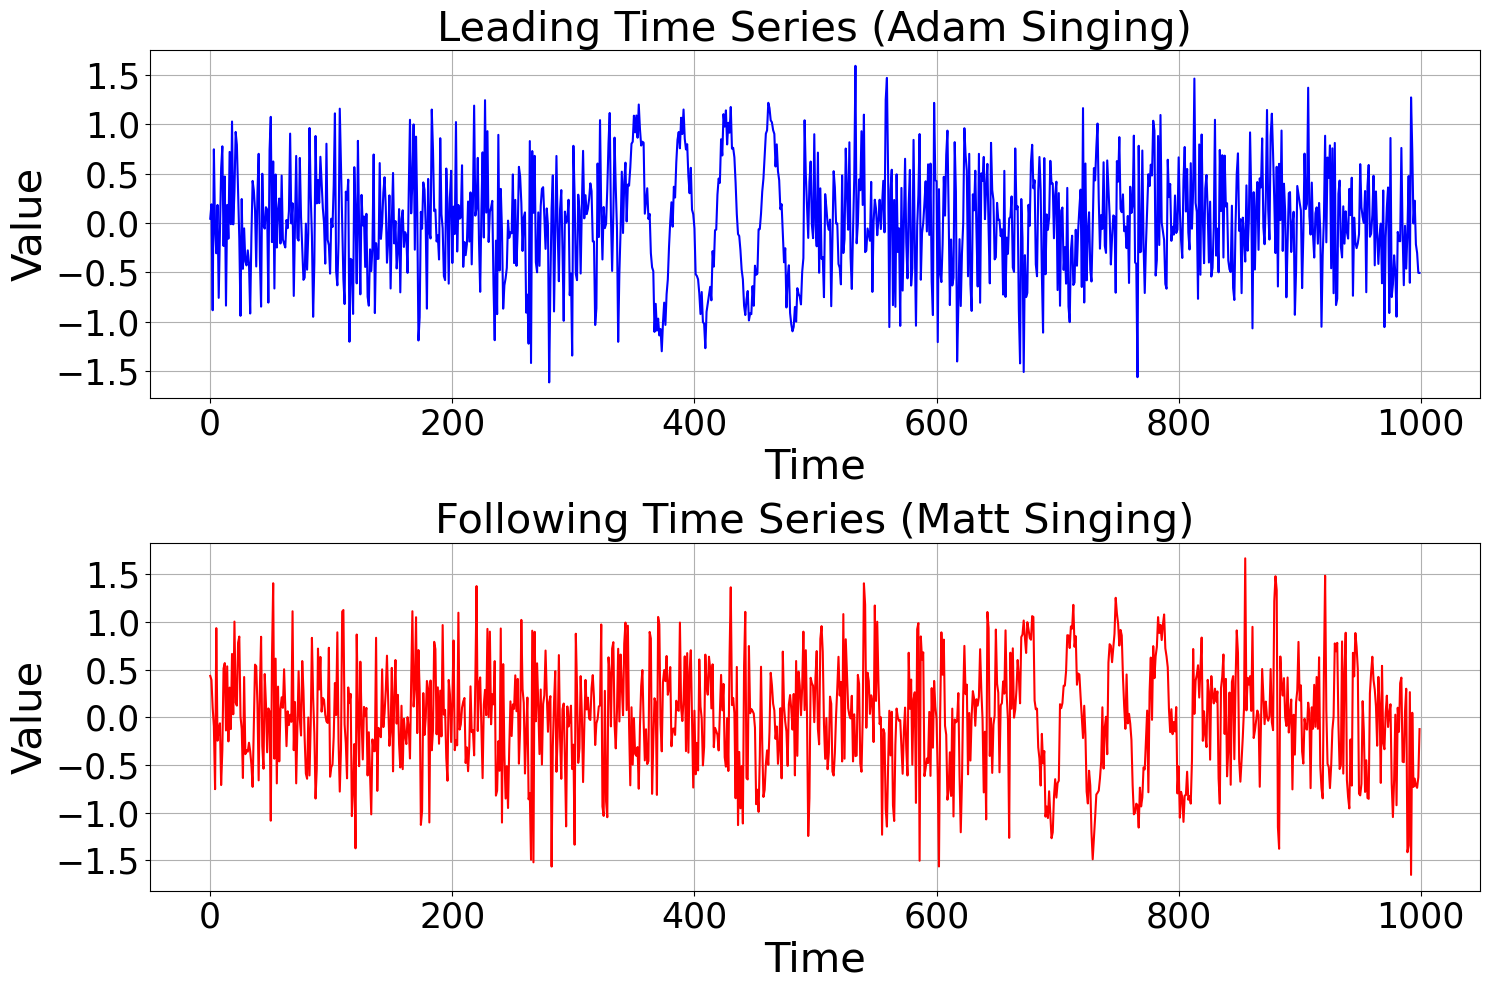

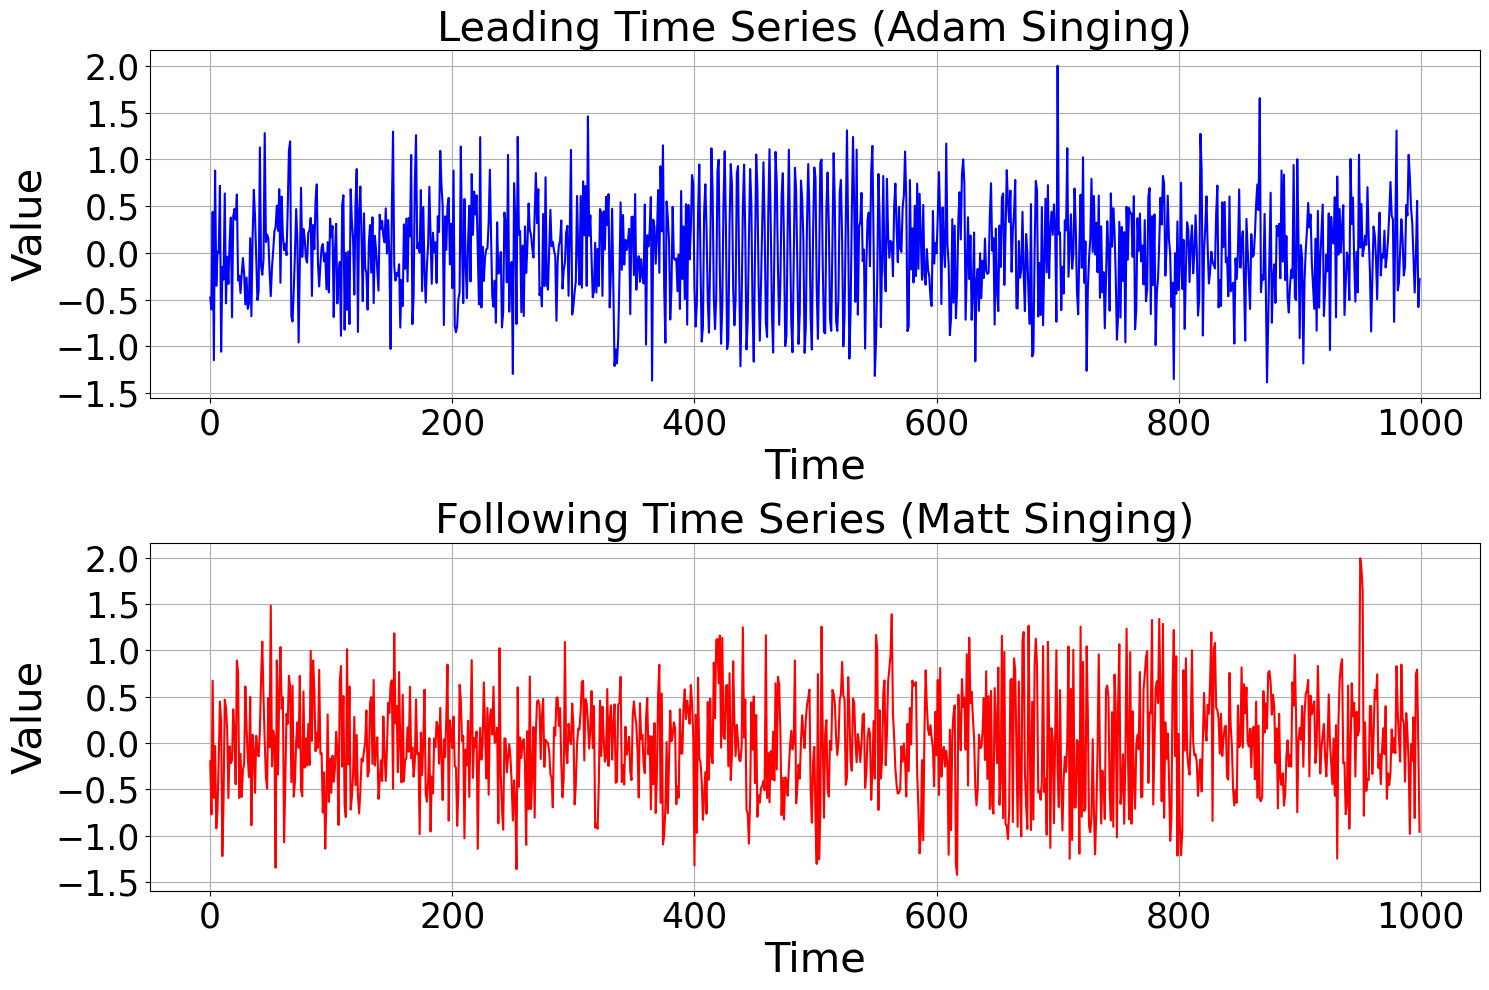

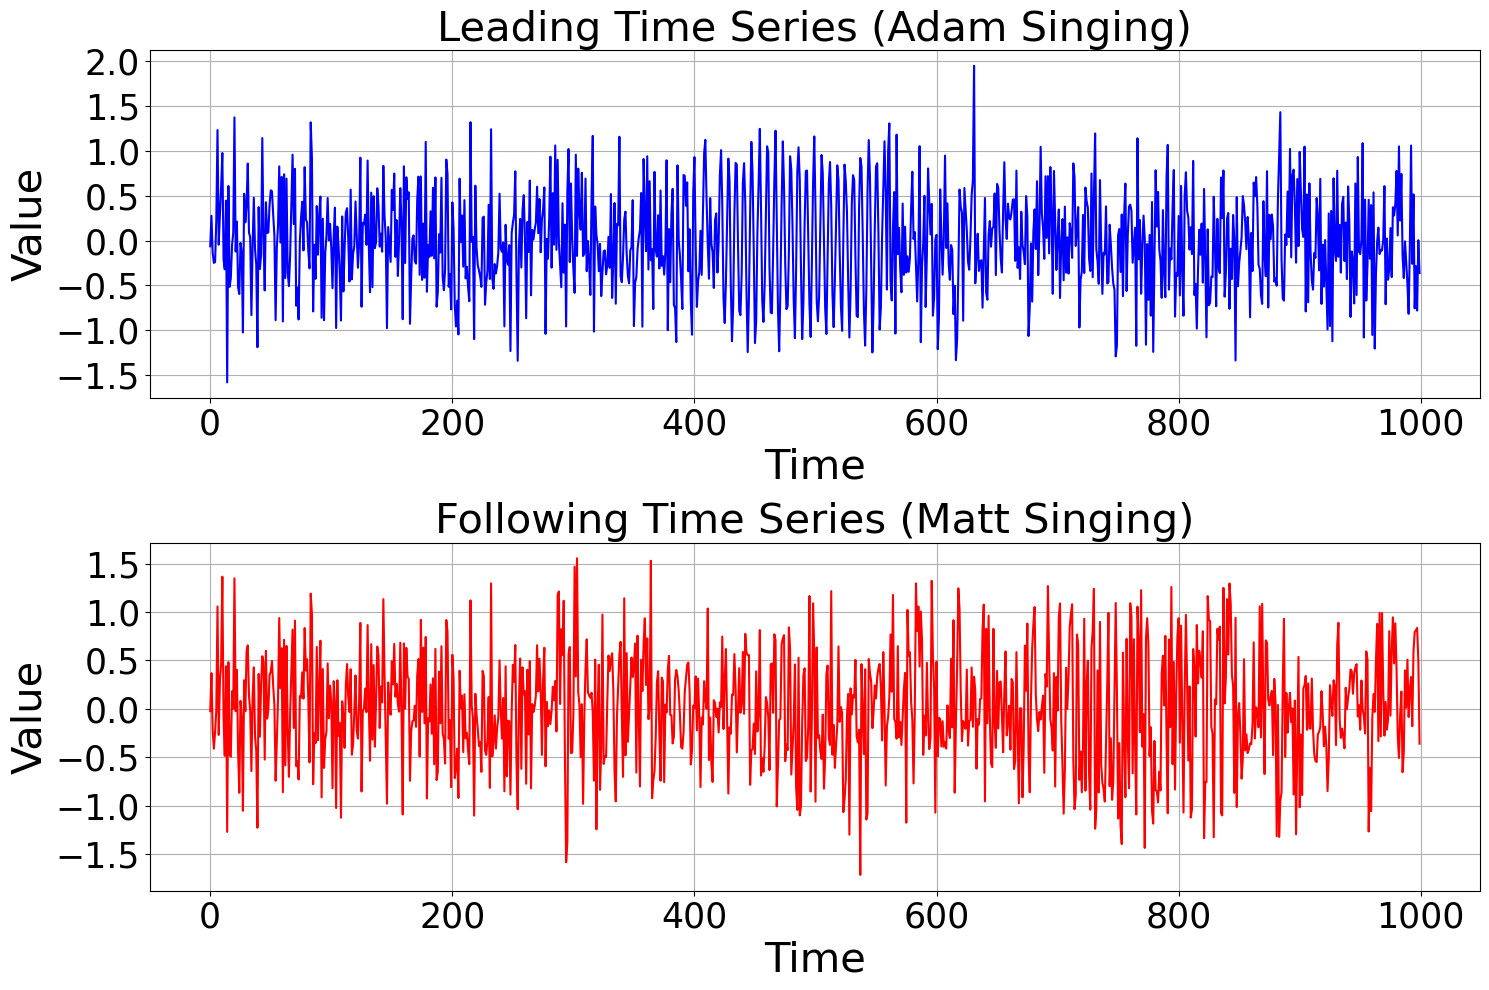

In [14]:
for i in range(3): leadfollow_visualization(leader_list_1[i][0],follower_list_1[i][0])

In [15]:
leader_list_2   = [leading_ts(randseed=i,k_motif=10,varied_len=False)            for i in range(1000)]
follower_list_2 = [following_ts(leader_list_2[i],randseed= i,uncontinuous=False) for i in range(1000)]

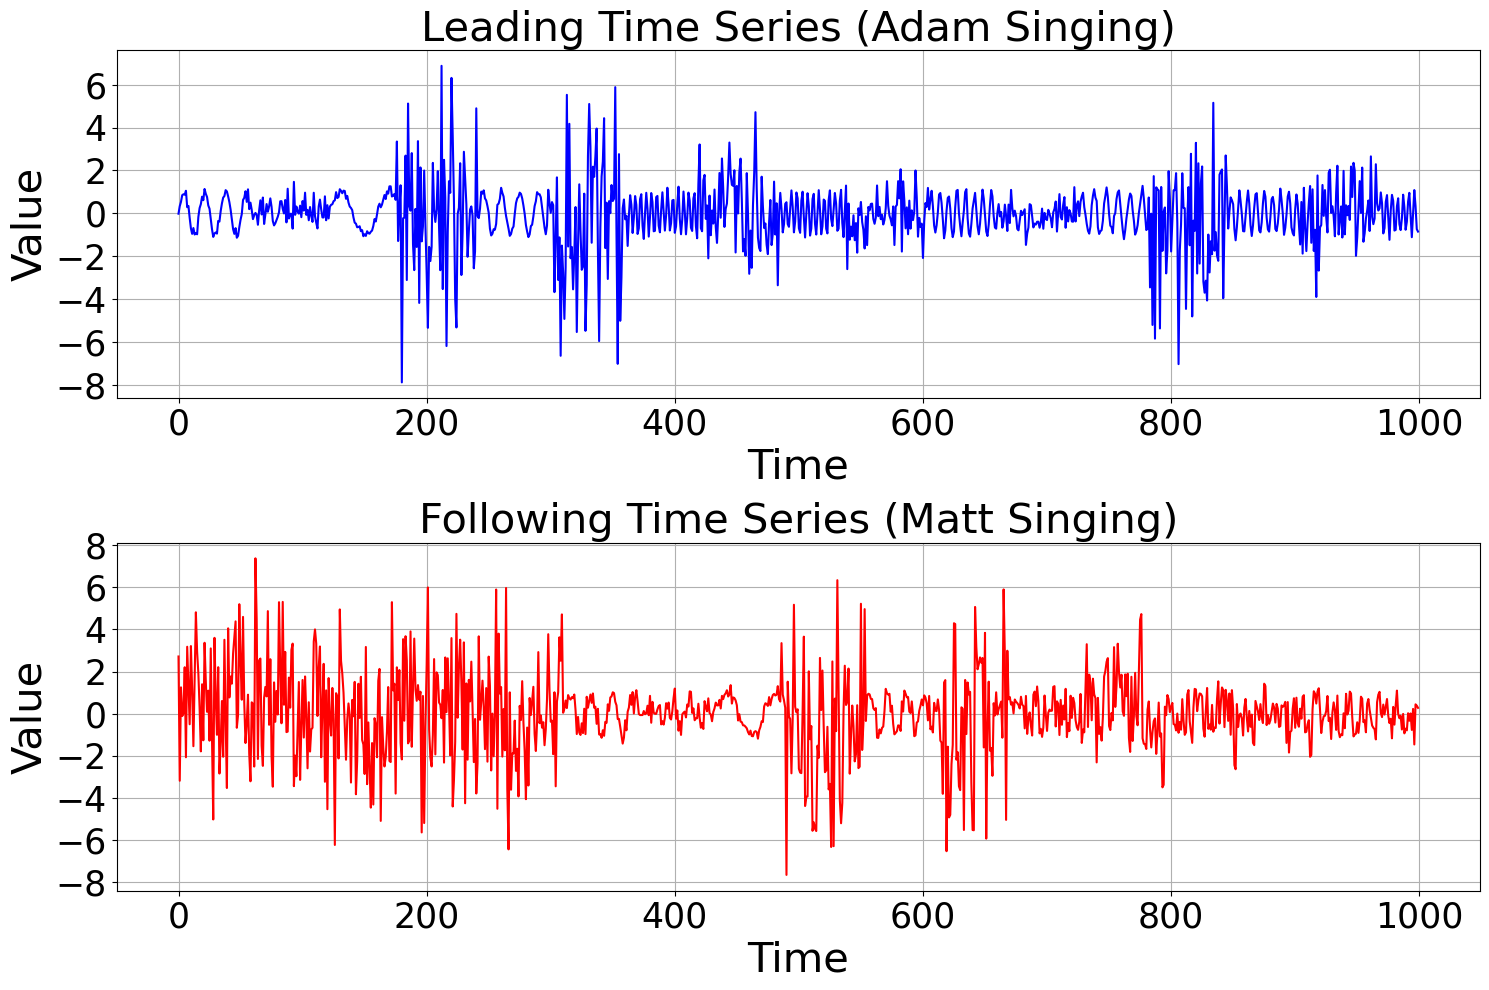

In [16]:
leadfollow_visualization(leader_list_2[45][0],follower_list_2[45][0])

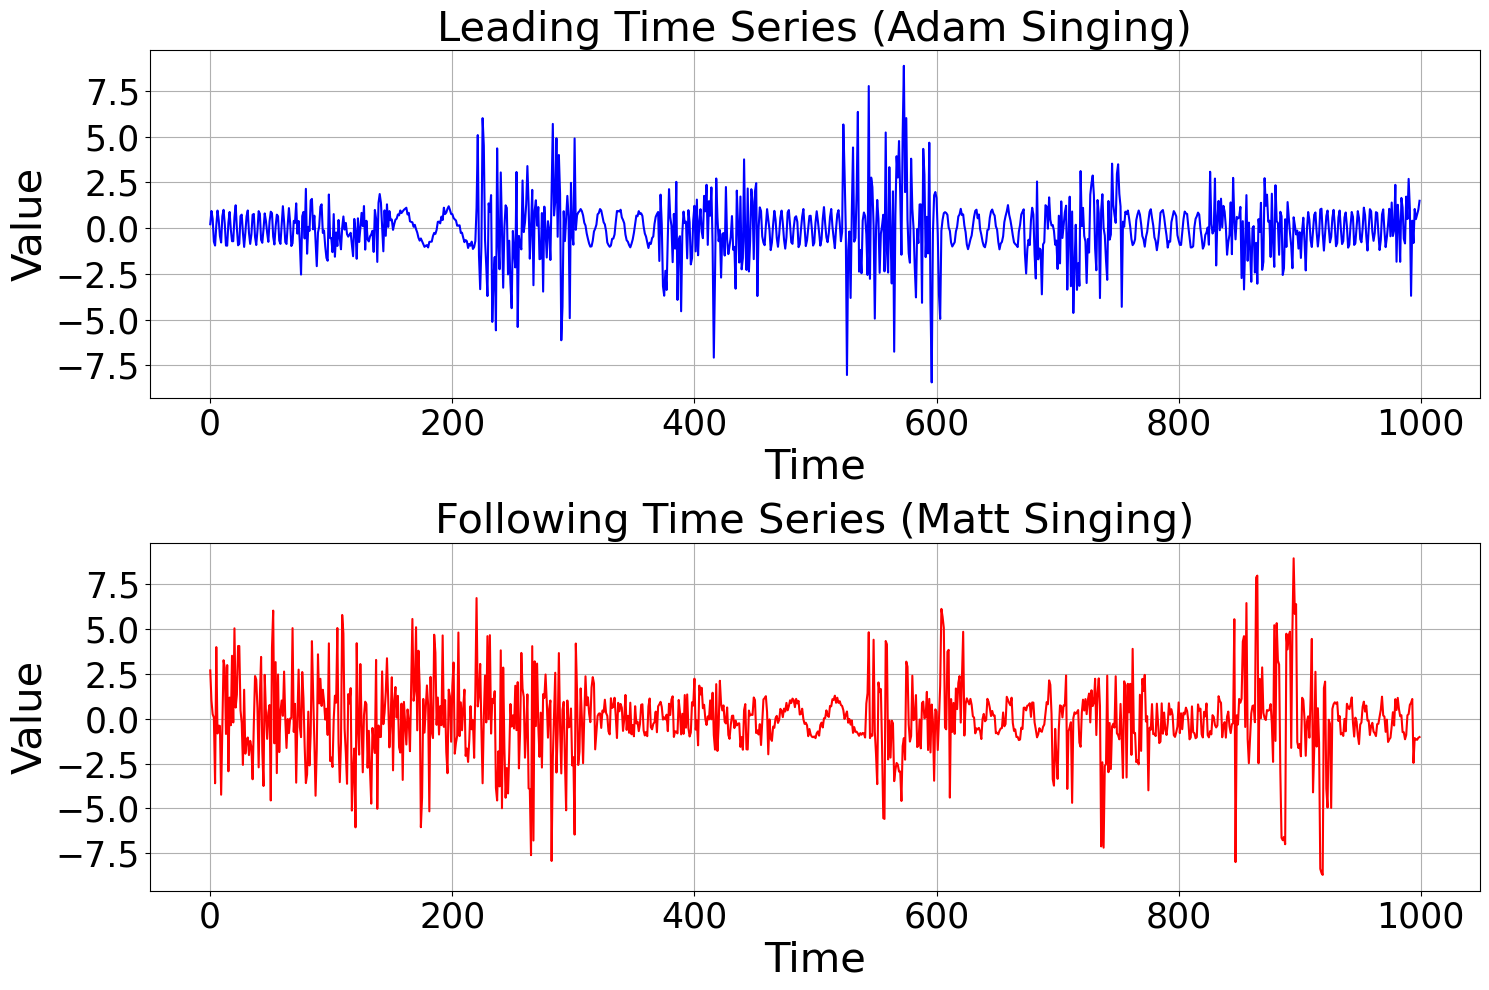

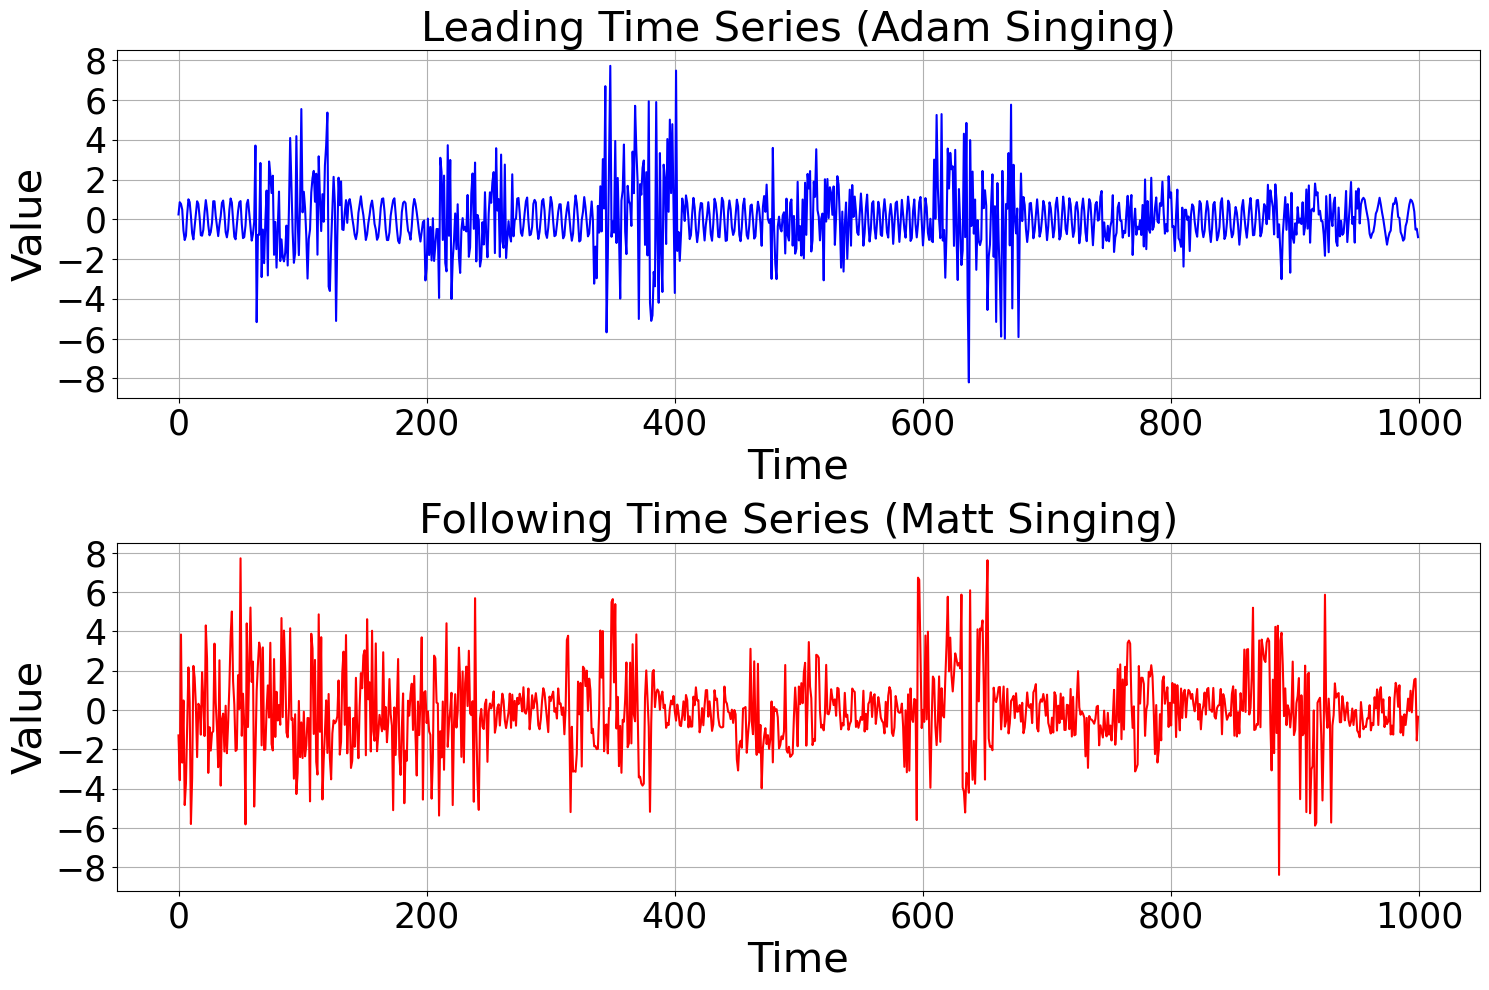

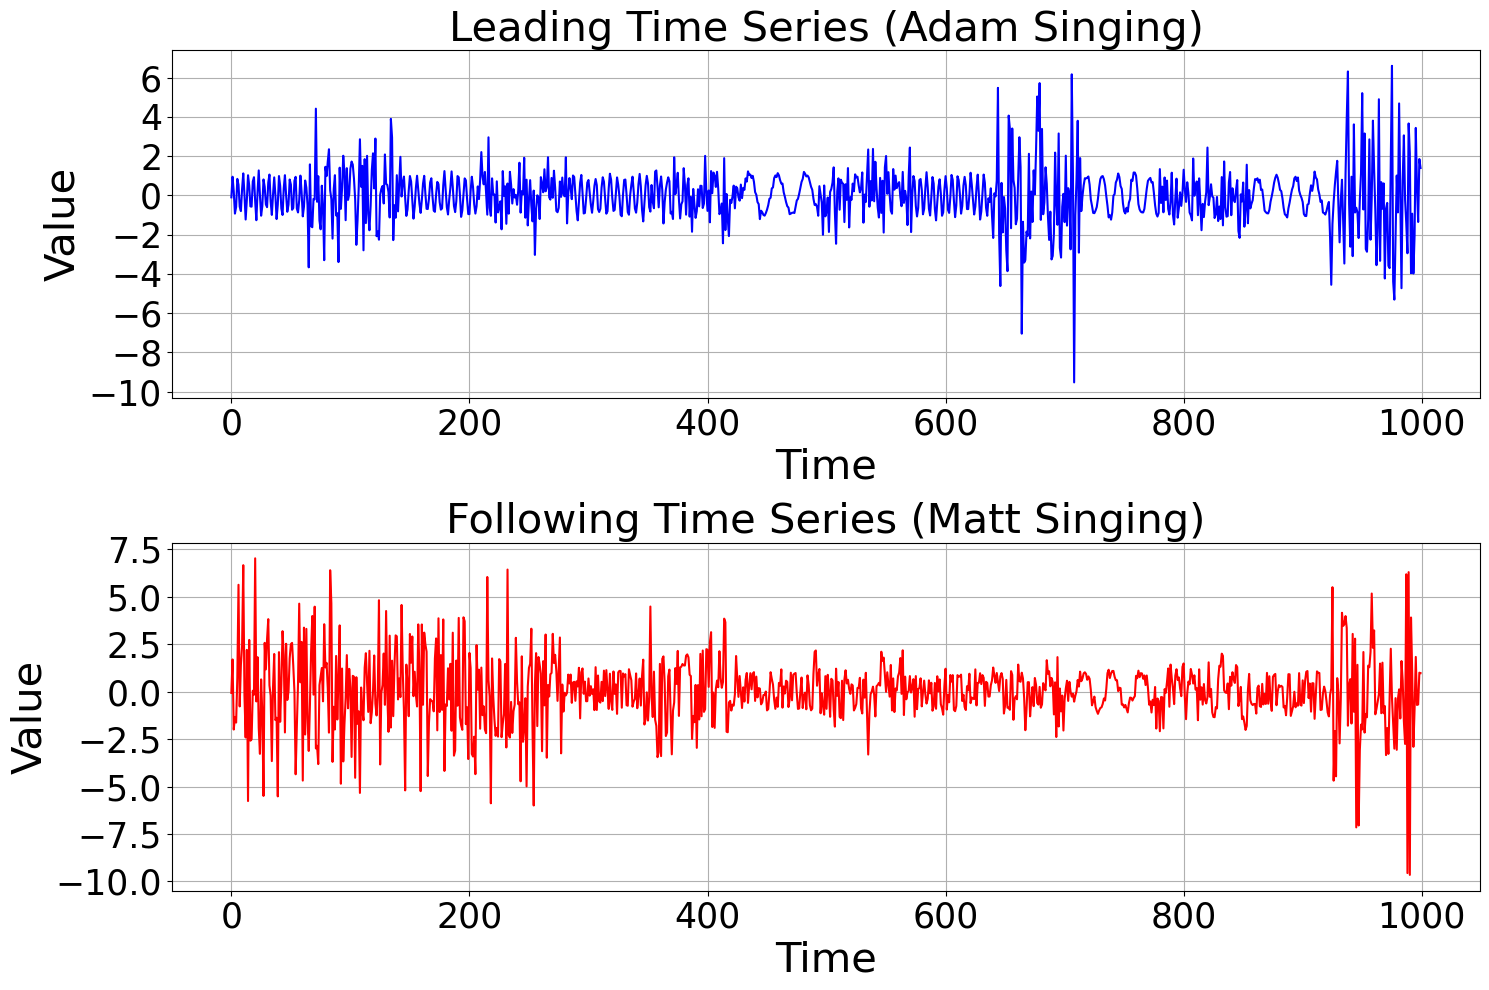

In [17]:
for i in range(3): leadfollow_visualization(leader_list_2[i][0],follower_list_2[i][0])

In [18]:
leader_list_3   = [leading_ts(randseed=i,k_motif=10,varied_len=False)           for i in range(1000)]
follower_list_3 = [following_ts(leader_list_3[i],randseed= i,uncontinuous=True) for i in range(1000)]

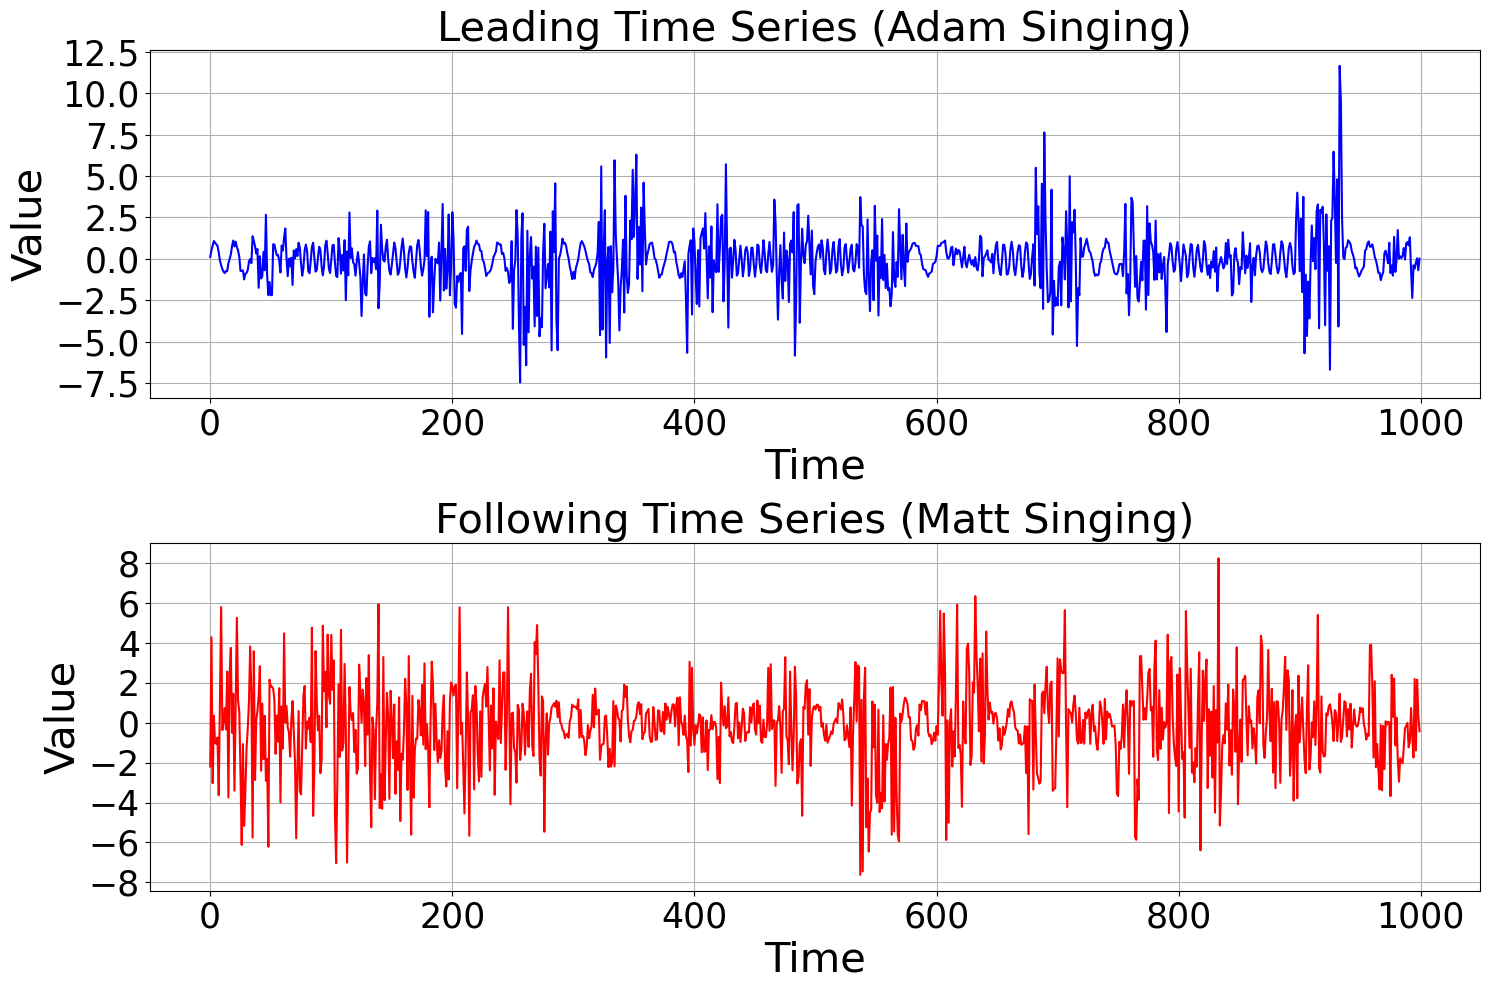

In [19]:
leadfollow_visualization(leader_list_3[100][0][:],follower_list_3[100][0][:])

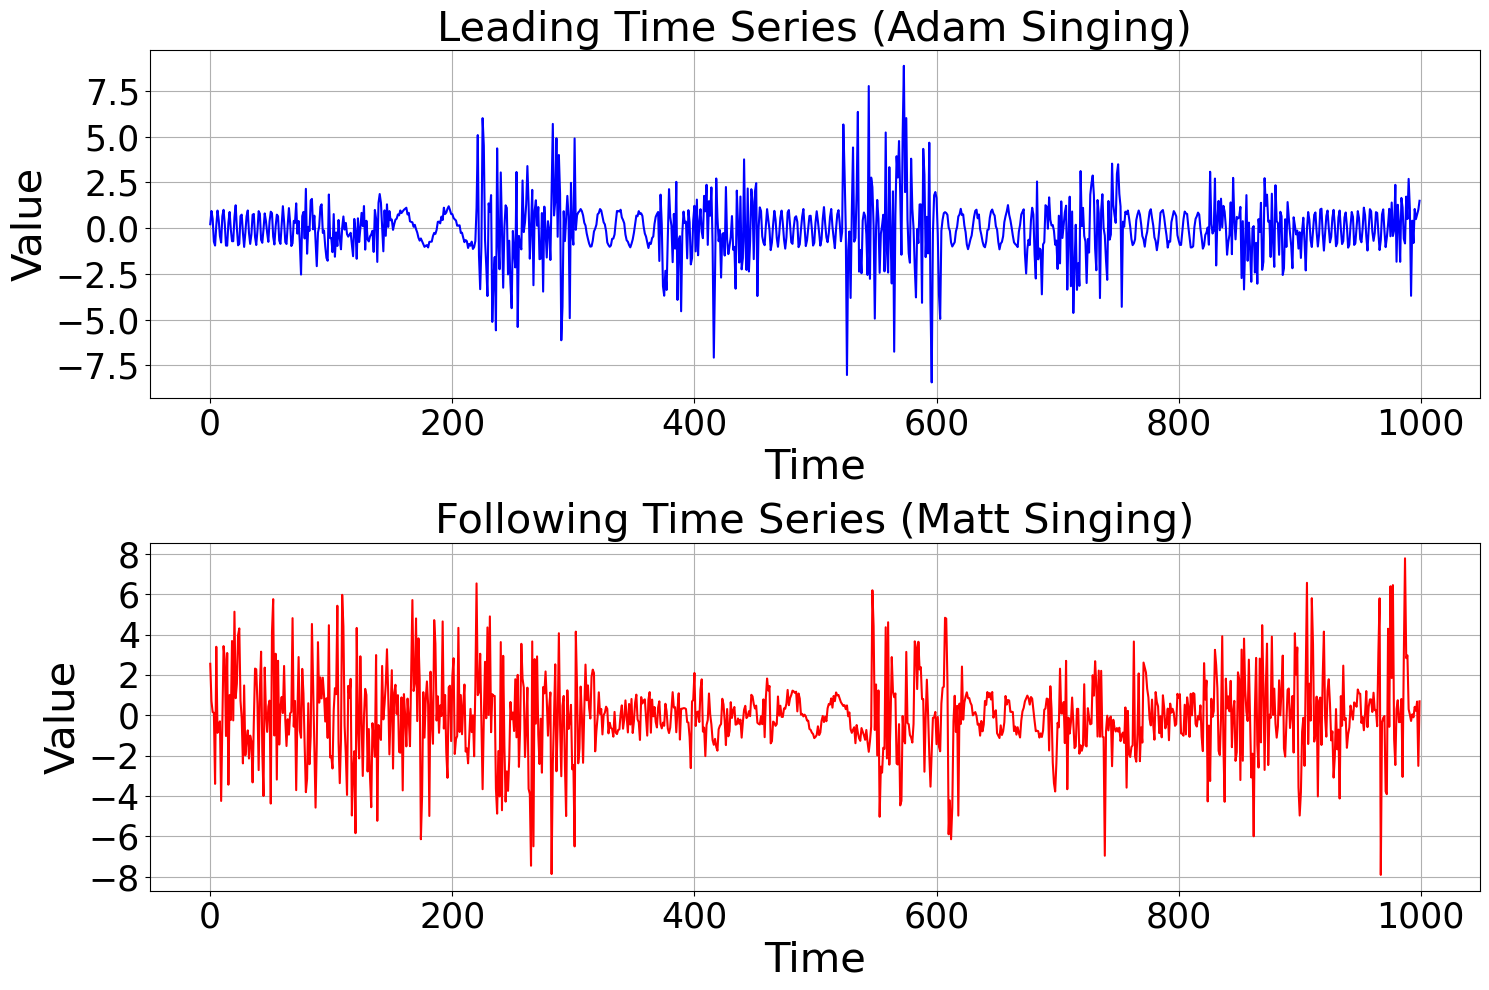

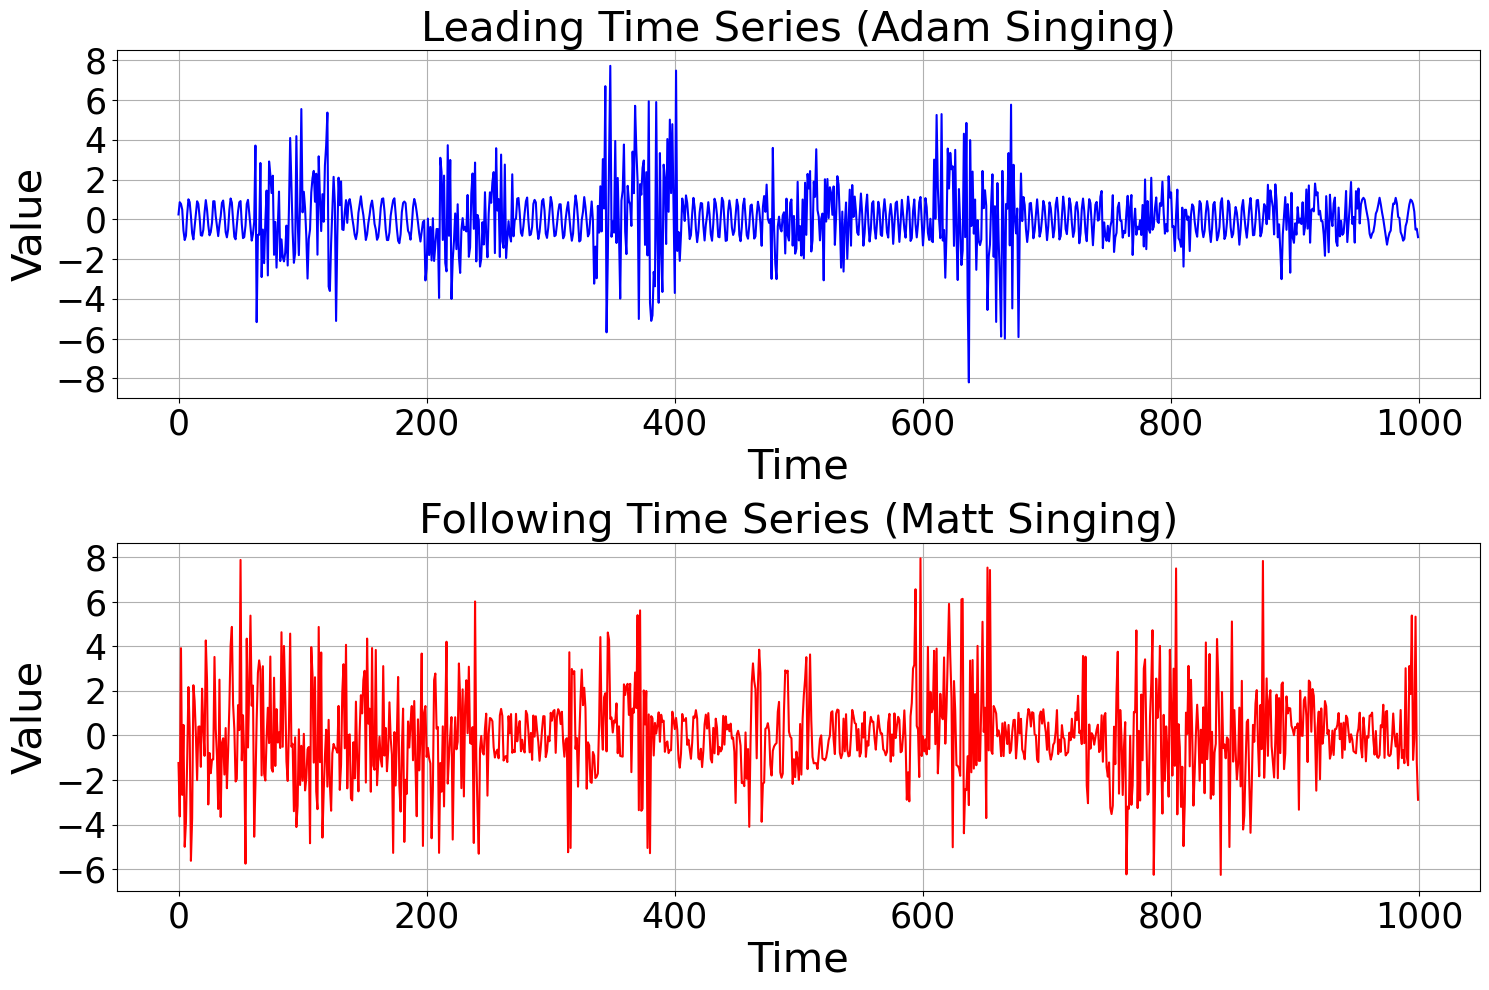

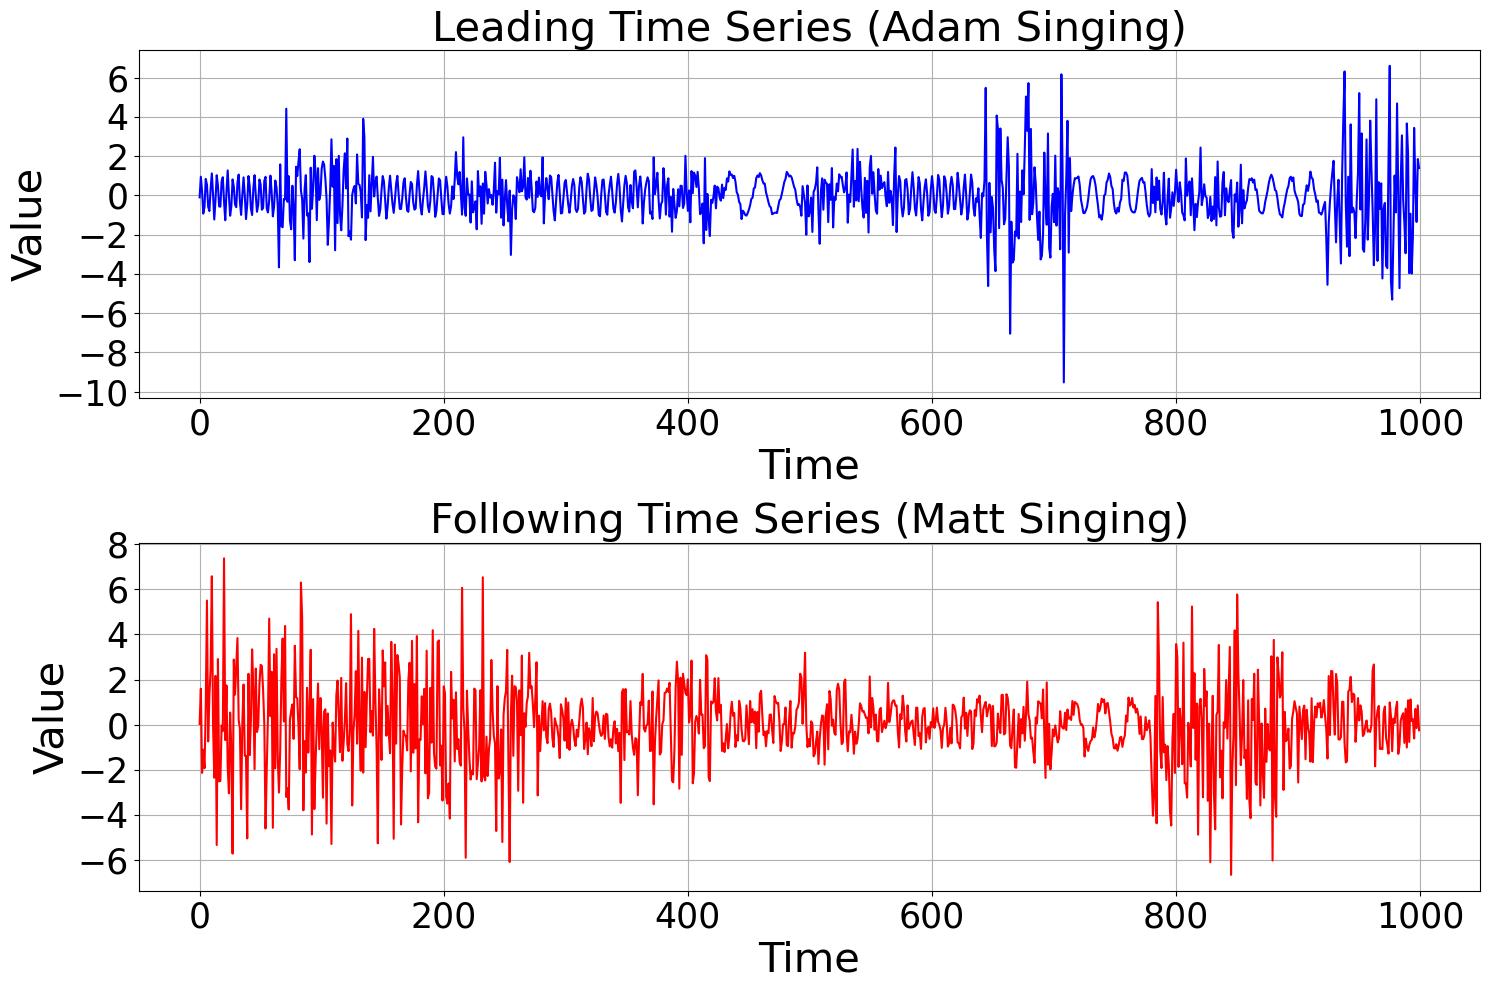

In [20]:
for i in range(3): leadfollow_visualization(leader_list_3[i][0],follower_list_3[i][0])

# Methods

In [21]:
def gap_fill(timeseries,thres=0.1):

    threshold = int((len(timeseries))*thres)

    for i in range(len(timeseries)-1):
        
        previous_element = timeseries[i]
        next_element     = timeseries[i+1]

        gap = next_element-previous_element

        if (gap < threshold) and (1<gap):
            new_elements = np.array([i for i in range(previous_element+1,next_element)])
            timeseries = np.insert(timeseries, i+1, new_elements)
    
    return timeseries

In [22]:
from scipy.signal import correlate
from scipy.signal import correlation_lags

def shift_for_maximum_correlation(x, y):
    correlation = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]
    return lag

def following_relation_method(lead_ts,follow_ts,wd=300,gap=10):
    lrmp,_ = matrixProfile.stamp(follow_ts,wd,lead_ts)
    frmp,_ = matrixProfile.stamp(lead_ts,wd,follow_ts)

    #========================================================
    #motif 

    pertile = 50-gap 

    lead = lrmp <np.percentile(lrmp, pertile)
    index_p_lrmp = np.where(lead)[0]
    
    follow = frmp <np.percentile(frmp, pertile)
    index_p_frmp = np.where(follow)[0]

    #========================================================
    #discord

    pertile = 50+gap

    lead = lrmp > np.percentile(lrmp, pertile)
    discord_index_p_lrmp = np.where(lead)[0]
    
    follow = frmp >np.percentile(frmp, pertile)
    discord_index_p_frmp = np.where(follow)[0]

    #========================================================

    new_index_lead = np.setdiff1d(gap_fill(index_p_lrmp),
                                  gap_fill(discord_index_p_lrmp))
    new_index_follow = np.setdiff1d(gap_fill(index_p_frmp),
                                    gap_fill(discord_index_p_frmp))

    #========================================================

    index_lead      = (new_index_lead)[:len(new_index_follow)]
    norm_index_lead = index_lead/np.linalg.norm(index_lead)
    sum_index_lead = sum(norm_index_lead)

    index_follow = (new_index_follow)
    norm_index_follow = index_follow/np.linalg.norm(index_follow)
    sum_index_follow = sum(norm_index_follow)

    lead_result = sum_index_follow>sum_index_lead

    return lead_result

In [23]:
def FLICA(leading_signal,following_signal):
    alignment = dtw(following_signal,leading_signal,
                keep_internals=True
                #,window_type = "sakoechiba"
                ,window_args= {"window_size": np.ceil(len(leading_signal)*0.1)})
    
    dtwIndexVec = alignment.index1[1:len(leading_signal)]-alignment.index2[1:len(leading_signal)]
    follVal = np.mean(np.sign(dtwIndexVec))
    
    return follVal>0

In [24]:
def max_correlation(x, y):
    correlation = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]

    return lag < 0

In [25]:
def following_relation_method(lead_ts,follow_ts,wd=300,gap=10):

    following_motif_index = [None,None]

    leader_mp,_   = matrixProfile.stamp(follow_ts,wd,lead_ts)
    follower_mp,_ = matrixProfile.stamp(lead_ts,wd,follow_ts)

    rmp = [follower_mp,leader_mp]

    for i in range(2):

        motif_percentile = 50-gap 
        
        motif_index = rmp[i] <np.percentile(rmp[i], motif_percentile)
        motif_index_mp = np.where(motif_index)[0] 

        following_motif_index[i] = motif_index_mp.copy()
        following_motif_index[i] = list(set(following_motif_index[i]))

    #=========================================================================

    following_motif_index[1] = following_motif_index[1][:len(following_motif_index[0])]

    lead_index   = list(following_motif_index[1])
    follow_index = list(following_motif_index[0])

    max_leader   = len(leader_mp)
    max_follower = len(follower_mp)
    normalized_x = lambda x,max : (x - 0) / (max - 0)

    lead_index_norm   = [normalized_x(x,max_leader) for x in lead_index] 
    follow_index_norm = [normalized_x(x,max_follower) for x in follow_index]

    lead_result_value = np.mean(np.array(follow_index_norm)-np.array(lead_index_norm))

    #lead_result = np.array(following_motif_index[0])-np.array(following_motif_index[1])
    #lead_result_value = np.mean(np.array(following_motif_index[0])-np.array(following_motif_index[1]))
    #lead_result       = lead_result_value>0
    #normalized_x = lambda x : (x.mean() - x.min()) / (x.max() - x.min())
    #standardized_x = lambda x : (x - x.mean()) / x.std()
    #lead_result_value = normalized_x(lead_result)
    lead_result       = lead_result_value>0

    """
    def binary_mark(arr_index,arr):
        arr   = np.zeros(len(arr))
        for index in arr_index:
            if index < len(arr):
                arr[index] = 1
        return arr
    
    arr = np.arange(len(follower_mp))

    lead_index   = binary_mark(np.array(following_motif_index[1]),arr)
    follow_index = binary_mark(np.array(following_motif_index[0]),arr)

    lead_result = follow_index-lead_index
    follVol = np.mean(np.sign(lead_result))

    lead_result = follVol>0
    """

    return lead_result


# Experiment

In [26]:
from tqdm.notebook import trange as tnrange

In [27]:
# 1.Motif Following Method 
p_result_motif1 = [following_relation_method(leader_list_1[i][0],follower_list_1[i][0]) for i in tnrange(1000)] #1
p_result_motif2 = [following_relation_method(leader_list_2[i][0],follower_list_2[i][0]) for i in tnrange(1000)] #2
p_result_motif3 = [following_relation_method(leader_list_3[i][0],follower_list_3[i][0]) for i in tnrange(1000)] #3

n_result_motif1 = [following_relation_method(follower_list_1[i][0],leader_list_1[i][0]) for i in tnrange(1000)] #4
n_result_motif2 = [following_relation_method(follower_list_2[i][0],leader_list_2[i][0]) for i in tnrange(1000)] #5
n_result_motif3 = [following_relation_method(follower_list_3[i][0],leader_list_3[i][0]) for i in tnrange(1000)] #6

# 2.FLICA
#p_result_FLICA1 = [FLICA(leader_list_1[i][0],follower_list_1[i][0]) for i in tnrange(1000)] #7
#p_result_FLICA2 = [FLICA(leader_list_2[i][0],follower_list_2[i][0]) for i in tnrange(1000)] #8
#p_result_FLICA3 = [FLICA(leader_list_3[i][0],follower_list_3[i][0]) for i in tnrange(1000)] #9

#n_result_FLICA1 = [FLICA(follower_list_1[i][0],leader_list_1[i][0]) for i in tnrange(1000)] #10
#n_result_FLICA2 = [FLICA(follower_list_2[i][0],leader_list_2[i][0]) for i in tnrange(1000)] #11
#n_result_FLICA3 = [FLICA(follower_list_3[i][0],leader_list_3[i][0]) for i in tnrange(1000)] #12

# 3.Cross Correlation
p_result_max_correlation1 = [max_correlation(leader_list_1[i][0],follower_list_1[i][0]) for i in tnrange(1000)] #13
p_result_max_correlation2 = [max_correlation(leader_list_2[i][0],follower_list_2[i][0]) for i in tnrange(1000)] #14
p_result_max_correlation3 = [max_correlation(leader_list_3[i][0],follower_list_3[i][0]) for i in tnrange(1000)] #15

n_result_max_correlation1 = [max_correlation(follower_list_1[i][0],leader_list_1[i][0]) for i in tnrange(1000)] #16
n_result_max_correlation2 = [max_correlation(follower_list_2[i][0],leader_list_2[i][0]) for i in tnrange(1000)] #17
n_result_max_correlation3 = [max_correlation(follower_list_3[i][0],leader_list_3[i][0]) for i in tnrange(1000)] #18

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
n_dataset = 1000

In [29]:
unique_elements, counts = np.unique(p_result_motif1[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_motif1:", counts)

unique_elements, counts = np.unique(p_result_motif2[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_motif2:", counts)

unique_elements, counts = np.unique(p_result_motif3[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_motif3:", counts)

#=====================================================================

unique_elements, counts = np.unique(n_result_motif1[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_motif1:", counts)

unique_elements, counts = np.unique(n_result_motif2[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_motif2:", counts)

unique_elements, counts = np.unique(n_result_motif3[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_motif3:", counts)

Unique elements: [False  True]
Counts p_result_motif1: [  3 997]
Unique elements: [ True]
Counts p_result_motif2: [1000]
Unique elements: [False  True]
Counts p_result_motif3: [ 12 988]
Unique elements: [False  True]
Counts n_result_motif1: [994   6]
Unique elements: [False  True]
Counts n_result_motif2: [999   1]
Unique elements: [False  True]
Counts n_result_motif3: [983  17]


In [30]:
unique_elements, counts = np.unique(p_result_FLICA1[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_FLICA1:", counts)

unique_elements, counts = np.unique(p_result_FLICA2[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_FLICA2:", counts)

unique_elements, counts = np.unique(p_result_FLICA3[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_FLICA3:", counts)

#=====================================================================

unique_elements, counts = np.unique(n_result_FLICA1[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_FLICA1:", counts)

unique_elements, counts = np.unique(n_result_FLICA2[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_FLICA2:", counts)

unique_elements, counts = np.unique(n_result_FLICA3[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_FLICA3:", counts)

NameError: name 'p_result_FLICA1' is not defined

In [31]:
unique_elements, counts = np.unique(p_result_max_correlation1[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_max_correlation1:", counts)

unique_elements, counts = np.unique(p_result_max_correlation2[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_max_correlation2:", counts)

unique_elements, counts = np.unique(p_result_max_correlation3[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts p_result_max_correlation3:", counts)

#=====================================================================

unique_elements, counts = np.unique(n_result_max_correlation1[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_max_correlation1:", counts)

unique_elements, counts = np.unique(n_result_max_correlation2[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_max_correlation2:", counts)

unique_elements, counts = np.unique(n_result_max_correlation3[:n_dataset], return_counts=True)
print("Unique elements:", unique_elements)
print("Counts n_result_max_correlation3:", counts)

Unique elements: [False  True]
Counts p_result_max_correlation1: [ 14 986]
Unique elements: [False  True]
Counts p_result_max_correlation2: [128 872]
Unique elements: [False  True]
Counts p_result_max_correlation3: [316 684]
Unique elements: [False]
Counts n_result_max_correlation1: [1000]
Unique elements: [False  True]
Counts n_result_max_correlation2: [872 128]
Unique elements: [False  True]
Counts n_result_max_correlation3: [684 316]


In [32]:
from sklearn.metrics import confusion_matrix

y_true = np.hstack([[True]*n_dataset,[False]*n_dataset])

y_pred_result_motif1 = np.hstack([p_result_motif1[:n_dataset],n_result_motif1[:n_dataset]])
y_pred_result_motif2 = np.hstack([p_result_motif2[:n_dataset],n_result_motif2[:n_dataset]])
y_pred_result_motif3 = np.hstack([p_result_motif3[:n_dataset],n_result_motif3[:n_dataset]])

cm_result_motif1 = confusion_matrix(y_true, y_pred_result_motif1)
cm_result_motif2 = confusion_matrix(y_true, y_pred_result_motif2)
cm_result_motif3 = confusion_matrix(y_true, y_pred_result_motif3)

#=======================================================================================

#y_pred_result_FLICA1 = np.hstack([p_result_FLICA1[:n_dataset],n_result_FLICA1[:n_dataset]])
#y_pred_result_FLICA2 = np.hstack([p_result_FLICA2[:n_dataset],n_result_FLICA2[:n_dataset]])
#y_pred_result_FLICA3 = np.hstack([p_result_FLICA3[:n_dataset],n_result_FLICA3[:n_dataset]])

#cm_result_FLICA1 = confusion_matrix(y_true, y_pred_result_FLICA1)
#cm_result_FLICA2 = confusion_matrix(y_true, y_pred_result_FLICA2)
#cm_result_FLICA3 = confusion_matrix(y_true, y_pred_result_FLICA3)

#=======================================================================================

y_pred_result_max_correlation1 = np.hstack([p_result_max_correlation1[:n_dataset],n_result_max_correlation1[:n_dataset]])
y_pred_result_max_correlation2 = np.hstack([p_result_max_correlation2[:n_dataset],n_result_max_correlation2[:n_dataset]])
y_pred_result_max_correlation3 = np.hstack([p_result_max_correlation3[:n_dataset],n_result_max_correlation3[:n_dataset]])

cm_result_max_correlation1 = confusion_matrix(y_true, y_pred_result_max_correlation1)
cm_result_max_correlation2 = confusion_matrix(y_true, y_pred_result_max_correlation2)
cm_result_max_correlation3 = confusion_matrix(y_true, y_pred_result_max_correlation3)

In [33]:
def confusion_matrix(cm_result):
    TP = cm_result[1, 1]
    TN = cm_result[0, 0]
    FP = cm_result[0, 1]
    FN = cm_result[1, 0]

    def f1_score(TP, TN, FP, FN):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * (precision * recall) / (precision + recall)
        return precision,recall,f1
    
    precision,recall,f1 = f1_score(TP, TN, FP, FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return TP,TN,FP,FN,precision,recall,f1,accuracy

In [34]:
def confusion_matrix_many(cm_result1,cm_result2,cm_result3):
    TP = cm_result1[1, 1]+cm_result2[1, 1]+cm_result3[1, 1]
    TN = cm_result1[0, 0]+cm_result2[0, 0]+cm_result3[0, 0]
    FP = cm_result1[0, 1]+cm_result2[0, 1]+cm_result3[0, 1]
    FN = cm_result1[1, 0]+cm_result2[1, 0]+cm_result3[1, 0]

    def f1_score(TP, TN, FP, FN):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * (precision * recall) / (precision + recall)
        return precision,recall,f1
    
    precision,recall,f1 = f1_score(TP, TN, FP, FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return TP,TN,FP,FN,precision,recall,f1,accuracy

In [35]:
data = [
    confusion_matrix(cm_result_motif1),
    confusion_matrix(cm_result_motif2),
    confusion_matrix(cm_result_motif3),
    confusion_matrix_many(cm_result_motif1,cm_result_motif2,cm_result_motif3)
]

# Create DataFrame
df = pd.DataFrame(data, columns=['TP', 'TN', 'FP', 'FN','Precision','Recall','F1','Accuracy'])
"""
df.index = [
    "motif and discord fixed length",
    "motif and discord varied length",
    "motif and discord varied length with uncontinous"
]
"""
df.index = ["Dataset1","Dataset2","Dataset3","Dataset1+2+3"]
df

,TP,TN,FP,FN,Precision,Recall,F1,Accuracy
Dataset1,997,994,6,3,0.994018,0.997,0.995507,0.9955
Dataset2,1000,999,1,0,0.999001,1.000,0.999500,0.9995
Dataset3,988,983,17,12,0.983085,0.988,0.985536,0.9855
Dataset1+2+3,2985,2976,24,15,0.992024,0.995,0.993510,0.9935


In [ ]:
data = [
    confusion_matrix(cm_result_FLICA1),
    confusion_matrix(cm_result_FLICA2),
    confusion_matrix(cm_result_FLICA3),
    confusion_matrix_many(cm_result_FLICA1,cm_result_FLICA2,cm_result_FLICA3)
]

# Create DataFrame
df = pd.DataFrame(data, columns=['TP', 'TN', 'FP', 'FN','Precision','Recall','F1','Accuracy'])
"""
df.index = [
    "motif and discord fixed length",
    "motif and discord varied length",
    "motif and discord varied length with uncontinous"
]
"""
df.index = ["Dataset1","Dataset2","Dataset3","Dataset1+2+3"]
df

,TP,TN,FP,FN,Precision,Recall,F1,Accuracy
Dataset1,693,693,307,307,0.693,0.693,0.693,0.693
Dataset2,732,732,268,268,0.732,0.732,0.732,0.732
Dataset3,663,663,337,337,0.663,0.663,0.663,0.663
Dataset1+2+3,2088,2088,912,912,0.696,0.696,0.696,0.696


In [36]:
data = [
    confusion_matrix(cm_result_max_correlation1),
    confusion_matrix(cm_result_max_correlation2),
    confusion_matrix(cm_result_max_correlation3),
    confusion_matrix_many(cm_result_max_correlation1,cm_result_max_correlation2,cm_result_max_correlation3)
]

# Create DataFrame
df = pd.DataFrame(data, columns=['TP', 'TN', 'FP', 'FN','Precision','Recall','F1','Accuracy'])
"""
df.index = [
    "motif and discord fixed length",
    "motif and discord varied length",
    "motif and discord varied length with uncontinous"
]
"""
df.index = ["Dataset1","Dataset2","Dataset3","Dataset1+2+3"]
df

,TP,TN,FP,FN,Precision,Recall,F1,Accuracy
Dataset1,986,1000,0,14,1.000000,0.986000,0.992951,0.993000
Dataset2,872,872,128,128,0.872000,0.872000,0.872000,0.872000
Dataset3,684,684,316,316,0.684000,0.684000,0.684000,0.684000
Dataset1+2+3,2542,2556,444,458,0.851306,0.847333,0.849315,0.849667
